# Initial setup

This section includes installing required libraries and loading environment variables, also making sure GPUs are visible.

### Libraries

In [1]:
import importlib.util

def install_if_not_exists(package_name, no_deps=False):
    spec = importlib.util.find_spec(package_name)
    if spec is None:
        print(f"[+] Installing {package_name}...")
        if no_deps is False:
          !pip install {package_name} --quiet
        else:
          !pip install --no-deps {package_name} --quiet
    else:
        print(f"[-] {package_name} is already installed.")

In [2]:
# training
install_if_not_exists("torch", no_deps=False)
install_if_not_exists("transformers", no_deps=False)

# datasets
install_if_not_exists("datasets", no_deps=False)
install_if_not_exists("scikit-learn", no_deps=False)
install_if_not_exists("pandas", no_deps=False)
install_if_not_exists("pymongo", no_deps=False)

# other
install_if_not_exists("matplotlib", no_deps=False)
install_if_not_exists("python-dotenv", no_deps=False)

# wandb and deps
install_if_not_exists("sentry-sdk")
install_if_not_exists("setproctitle", no_deps=False)
install_if_not_exists("wandb", no_deps=False)
install_if_not_exists("click", no_deps=False)
install_if_not_exists("docker-pycreds", no_deps=False)
install_if_not_exists("nltk", no_deps=False)

[-] torch is already installed.
[-] transformers is already installed.
[-] datasets is already installed.
[+] Installing scikit-learn...
[-] pandas is already installed.
[-] pymongo is already installed.
[-] matplotlib is already installed.
[+] Installing python-dotenv...
[+] Installing sentry-sdk...
[-] setproctitle is already installed.
[-] wandb is already installed.
[-] click is already installed.
[+] Installing docker-pycreds...
[-] nltk is already installed.


In [3]:
# core
import os, logging, time, torch, gc, re
from dotenv import load_dotenv
import numpy as np

# dataset
from datasets import Dataset
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# training
import torch
from transformers import(
    EarlyStoppingCallback,
    AdamW,
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)


# evaluation
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns

In [4]:
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected:")

    # available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # GPU info
    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Current Memory Allocated: {torch.cuda.memory_allocated(i) / 1e6:.2f} MB")
        print(f"  Current Memory Cached: {torch.cuda.memory_reserved(i) / 1e6:.2f} MB")
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. GPUs detected:
Number of available GPUs: 3

GPU 0:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 1:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 2:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB


### Environment variables and constants

In [5]:
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
TOKEN = os.getenv("HUGGINGFACE_TOKEN")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [6]:
DATABASE_NAME = "APTs"

GPU check (Docker container will sometimes lose GPU visibility)

In [7]:
!nvidia-smi

Sun Jun 23 10:10:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:18:00.0 Off |                  N/A |
| 30%   32C    P8              39W / 350W |    398MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset loading


Initially, we will be building a dataset with raw text and tools. The dataset is stored in a MongoDB database, so we will have to fetch the data:

In [8]:
collection_name = "dataset"

In [9]:
client = MongoClient(CONNECTION_STRING)
db = client[DATABASE_NAME]

collection = db[collection_name]

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_corpus(text):
  """
  Preprocesses a given text by removing stopwords and setting lowercase.

  Args:
    text: The text to be preprocessed.

  Returns:
    The preprocessed text.
  """
  tokens = word_tokenize(text.lower())
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in tokens if token not in stop_words]

  preprocessed_text = ' '.join(filtered_tokens)

  return preprocessed_text

In [12]:
documents = collection.find()

data = []
for doc in documents:
  print(doc.keys())
  break

dict_keys(['_id', 'corpus', 'hash', 'techniques', 'tactics', 'procedures', 'IOCs', 'killchain_phase', 'apt_group'])


In [13]:
documents = collection.find()

data = []
for doc in documents:

    corpus = doc.get("corpus", "")
    tactics = doc.get("tactics", "")

    data.append({
        "corpus": preprocess_corpus(corpus),
        "tactics": tactics
    })

df = pd.DataFrame(data)

print(f"[+] Shape: {df.shape}")
df.head()

[+] Shape: (156, 2)


,corpus,tactics
0,decoding network data gh0st rat variant nccgro...,"[Execution, Persistence, Credential Access, Co..."
1,5www .prevailion.com /what-wicked-webs-we-unwe...,"[Credential Access, Defense Evasion, Exploitat..."
2,7www .mandiant.com /resources/blog/lightshift-...,"[Defense Evasion, Privilege Escalation, Execut..."
3,2015/11/24 russian financial cybercrime works ...,"[Credential Access, Exfiltration, Persistence]"
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,"[Persistence, Credential Access, Command and C..."


In [14]:
df['tactics_length'] = df['tactics'].apply(len)

df['tactics_length'].value_counts()

tactics_length
5     61
6     24
8     16
4     16
3     12
7     10
9      6
10     5
11     5
12     1
Name: count, dtype: int64

In [15]:
tactics = df['tactics'].apply(pd.Series).stack().reset_index(drop=True).unique()
one_hot_df = pd.get_dummies(df['tactics'].apply(pd.Series).stack()).groupby(level=0).sum()
one_hot_df = one_hot_df.reindex(columns=tactics, fill_value=0)

df_one_hot_encoded = df.drop(columns=['tactics']).join(one_hot_df)

In [16]:
df_one_hot_encoded

,corpus,tactics_length,Execution,Persistence,Credential Access,Collection,Defense Evasion,Exploitation,Privilege Escalation,Exfiltration,Command and Control,Discovery,Initial Access,Lateral Movement,Impact,Reconnaissance,Delivery,Resource Development
0,decoding network data gh0st rat variant nccgro...,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,5www .prevailion.com /what-wicked-webs-we-unwe...,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
2,7www .mandiant.com /resources/blog/lightshift-...,3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,2015/11/24 russian financial cybercrime works ...,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,3,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,first release time 14:32 may 27 2015 updated t...,4,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
152,10/1/2019 helo innti attack scan lastline http...,5,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0
153,9/9/2020 teamtnt activity tar gets eave scope ...,5,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
154,2stisc-gov-md.translate.goog /ro/stisc-atentie...,3,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

In [18]:
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["NCCL_SHM_DISABLE"] = "1"

# Dataset preparation

A custom dataset class `ClauseDataset` was created in order to be handled with data loaders (for Bert compatibility)

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

texts = df_one_hot_encoded['corpus'].tolist()
labels = df_one_hot_encoded.drop(columns=['corpus', 'tactics_length']).values

Small `TypeError` fix

In [21]:
def convert_to_float32(x):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        return np.array(x, dtype=np.float32)
    else:
        return np.float32(x)

Another small fix to ensure the array is 2D

In [24]:
# making sure they are all the same length
labels_list = []

for label in labels:
    labels_list.append(convert_to_float32(label))

max_length = max(len(label) for label in labels_list)
for i in range(len(labels_list)):
    if len(labels_list[i]) < max_length:
        labels_list[i] = np.pad(labels_list[i], (0, max_length - len(labels_list[i])), 'constant')

labels = np.vstack(labels_list) # stacking the labels into a 2D array

Generating the custom training and validation datasets

In [25]:
print(len(texts))
print(len(labels))

156
156


In [26]:
# 1. split into training and temporary (which will be divided in 2) datasets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)

# 2. split into validation and test (15% of total each)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# 3. tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# 4. create the datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Bert model and training

In [27]:
num_labels = labels.shape[1]
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [30]:
training_logs = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: w-dan (seclab-etsisi). Use `wandb login --relogin` to force relogin


/home/dani/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.718000
20,0.693700
30,0.653800
40,0.623300
50,0.594300
60,0.564100
70,0.537900
80,0.512200
90,0.491700
100,0.476100


In [31]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.39442160725593567, 'eval_runtime': 0.396, 'eval_samples_per_second': 58.075, 'eval_steps_per_second': 2.525, 'epoch': 30.0}


# Evaluation

In [33]:
def predict(val_dataset):
    predictions = trainer.predict(val_dataset)
    pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
    pred_labels = (pred_probs >= 0.5).int().numpy()
    return pred_labels

# Evaluate predictions function for multi-label classification
def evaluate_predictions(true_labels, pred_labels):
    target_names = [f'Class {i}' for i in range(true_labels.shape[1])]

    # Generate a classification report
    print(classification_report(true_labels, pred_labels, target_names=target_names))

    # Generate a multilabel confusion matrix
    cm = multilabel_confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrices for each class
    fig, axes = plt.subplots(nrows=cm.shape[0], figsize=(10, cm.shape[0] * 4))
    for i, ax in enumerate(axes):
        sns.heatmap(cm[i], annot=True, fmt='d', xticklabels=['Not ' + target_names[i], target_names[i]],
                    yticklabels=['Not ' + target_names[i], target_names[i]], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {target_names[i]}')

    plt.tight_layout()
    plt.show()

/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        22
     Class 1       1.00      1.00      1.00        23
     Class 2       0.00      0.00      0.00        11
     Class 3       0.00      0.00      0.00        10
     Class 4       0.78      1.00      0.88        18
     Class 5       0.00      0.00      0.00         0
     Class 6       0.00      0.00      0.00         5
     Class 7       0.00      0.00      0.00        10
     Class 8       0.78      1.00      0.88        18
     Class 9       0.00      0.00      0.00         6
    Class 10       1.00      1.00      1.00        23
    Class 11       0.00      0.00      0.00         4
    Class 12       0.00      0.00      0.00         3
    Class 13       0.00      0.00      0.00         0
    Class 14       0.00      0.00      0.00         0
    Class 15       0.00      0.00      0.00         0

   micro avg       0.90      0.68      0.78       153
   macro avg       0.28   

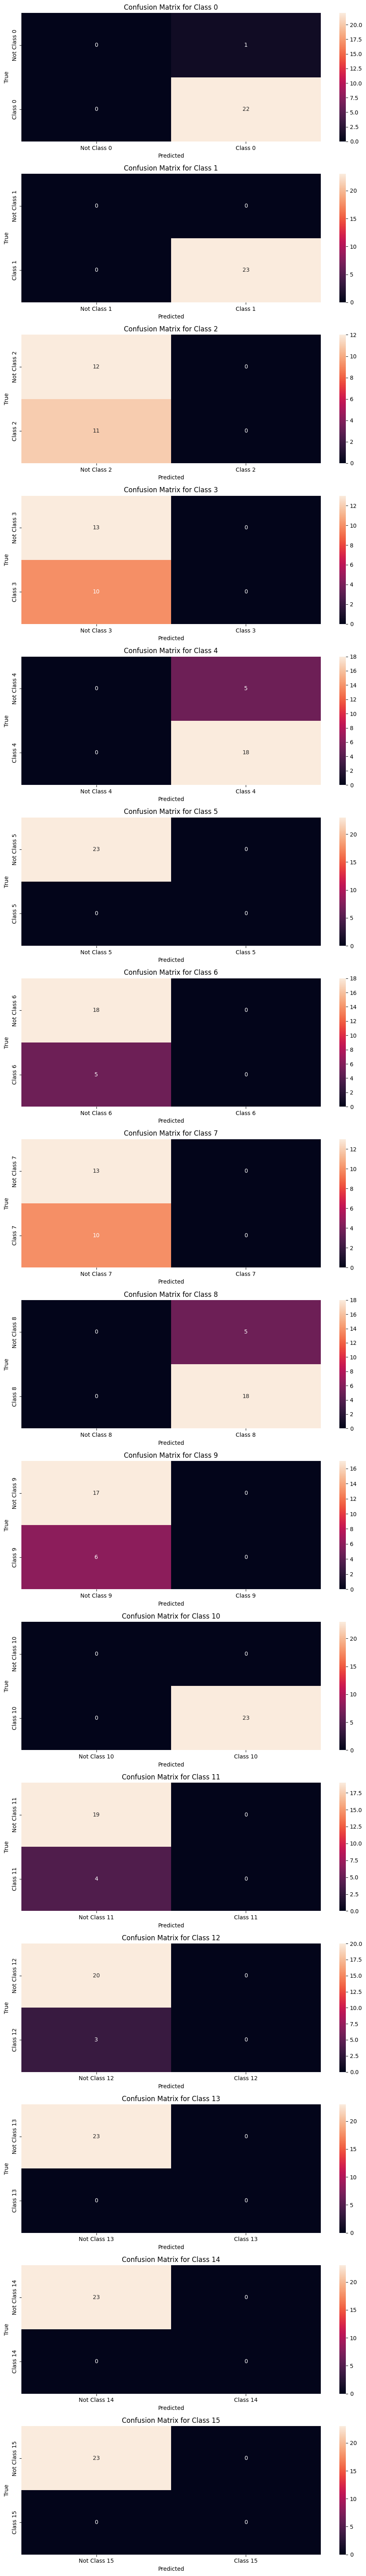

In [34]:
pred_labels = predict(val_dataset)
evaluate_predictions(val_labels, pred_labels)

/home/dani/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dani/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        23
     Class 1       0.83      1.00      0.91        20
     Class 2       0.00      0.00      0.00         5
     Class 3       0.00      0.00      0.00         6
     Class 4       0.87      1.00      0.93        20
     Class 5       0.00      0.00      0.00         1
     Class 6       0.00      0.00      0.00         0
     Class 7       0.00      0.00      0.00         6
     Class 8       0.83      1.00      0.91        20
     Class 9       0.00      0.00      0.00         4
    Class 10       0.96      1.00      0.98        23
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         2
    Class 13       0.00      0.00      0.00         0
    Class 14       0.00      0.00      0.00         0
    Class 15       0.00      0.00      0.00         0

   micro avg       0.89      0.80      0.84       133
   macro avg       0.28   

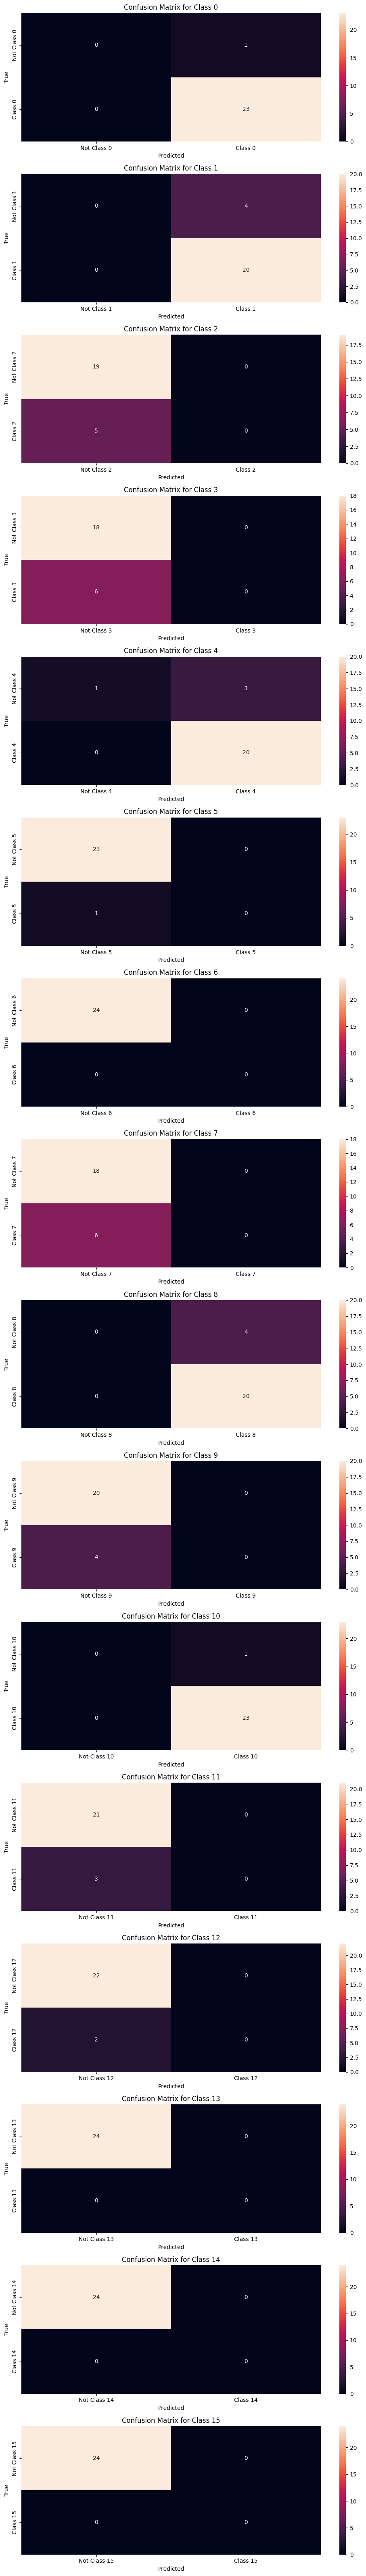

In [35]:
pred_labels_test = predict(test_dataset)
evaluate_predictions(test_labels, pred_labels_test)

In [37]:
def save_model(model, tokenizer, output_dir):
    """
    Saves the BERT model and tokenizer.

    Parameters:
    model (transformers.PreTrainedModel): The trained BERT model.
    tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    output_dir (str): The directory where the model and tokenizer will be saved.

    Returns:
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved in {output_dir}")

In [38]:
output_dir = './bert_multitag'
save_model(model, tokenizer, output_dir)

Model and tokenizer saved in ./bert_multitag
